# Importing Libraries, Setting Helper Fucnctions and Reading in Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import os
import statistics

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson


# an initial clean-up function
def clean_up(df,ds='rawdata1'):
    df["YEAR"] = df["YEAR"].astype('str')
    df["MONTH"] = df["MONTH"].astype('str')
    df["DATE"] = df["MONTH"] + '-' + df["YEAR"]
    df["DATE"] =  pd.to_datetime(df["DATE"], format="%m-%Y")
    df['half year'] = np.where(df['DATE'].dt.month.le(6), 'H1', 'H2')
    col = df['half year'] + '-' + df["YEAR"]
    
    if ds == 'rawdata1':
        df["CATEGORY_ID"] = df["CATEGORY_ID"].astype('str')
        df.insert(1,'HALF YEAR',col)
    else:
        df.insert(0,'HALF YEAR',col)
        
    df = df.drop(['YEAR','MONTH','half year'], axis=1)
    df = df.set_index('DATE')
    
    df["STORE"] = df["STORE"].astype('int')
    df["DAYPART"] = df["DAYPART"].astype('str')
    
    return df


# a function to produce pivot tables
def piv_fun(rawdata_1,rawdata_2, piv_type='store'):
    
    daypart_list = ['B','L','D']
    category_list = ['10','15','20','25','30','40','45','50','55','60','99']
    helper_list = ['B','L','D','store']

    if piv_type=='store':
        rawdata_1_filt = rawdata_1
        rawdata_2_filt = rawdata_2
    elif piv_type in daypart_list:
        rawdata_1_filt = rawdata_1[rawdata_1['DAYPART']==piv_type]
        rawdata_2_filt = rawdata_2[rawdata_2['DAYPART']==piv_type]
    else:
        rawdata_1_filt = rawdata_1[rawdata_1['CATEGORY_ID']==piv_type]
  
    # revenue pivot
    rawdata_1_filt_rev = pd.pivot_table(rawdata_1_filt, values='REVENUE_NET', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_rev.columns.name = None
    rawdata_1_filt_rev['Str Smpl Total']= rawdata_1_filt_rev.iloc[:,:].sum(axis=1)
    rawdata_1_filt_rev['Columbus_Region']= rawdata_1_filt_rev.iloc[:,2:4].sum(axis=1)

    # quantity pivot
    rawdata_1_filt_quan = pd.pivot_table(rawdata_1_filt, values='QTY', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_quan.columns.name = None
    rawdata_1_filt_quan['Str Smpl Total']= rawdata_1_filt_quan.iloc[:,:].sum(axis=1)
    rawdata_1_filt_quan['Columbus_Region']= rawdata_1_filt_quan.iloc[:,2:4].sum(axis=1)
    
    # customer count pivot
    if piv_type in helper_list:
        rawdata_2_custcnt = pd.pivot_table(rawdata_2_filt, values='CUSTOMER_COUNT', index=['DATE'],
                           columns=['STORE'], aggfunc="sum")
        rawdata_2_custcnt.columns.name = None
        rawdata_2_custcnt['Str Smpl Total']= rawdata_2_custcnt.iloc[:,:].sum(axis=1)
        rawdata_2_custcnt['Columbus_Region']= rawdata_2_custcnt.iloc[:,2:4].sum(axis=1)

    else:
        rawdata_2_custcnt = None
    
    return rawdata_1_filt_rev,rawdata_1_filt_quan,rawdata_2_custcnt

    
def plot_fun2(df,i,store,ax):
    
    if i==0:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Revenues')
        ax.tick_params(axis='x', rotation=45)

    if i==1:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Quantity')
        ax.tick_params(axis='x', rotation=45)
        
    if i+1==3:
        ax.plot(df[store])
        ax.set_title('Average Prices')
        ax.tick_params(axis='x', rotation=45)            
        

# Settings
pd.set_option('display.max_columns', 50)
os.chdir('C:/Users/darre/Documents/Restaurant-Pricing')

In [2]:
def plot_fun1(df,store,ax,**kwargs):
    
    # creating dictionaries to help with subplot titles
    dict_daypart = {0: 'Breakfast',
        1: 'Lunch',
        2: 'Dinner'}
    
    dict_category = {0: 'BREAKFAST',
        1: 'SENIORS MEALS',
        2: 'DINNER',
        3: 'DINNER ALA',
        4: 'LUNCH',
        5: 'SOUP SALAD',
        6: 'KIDS',
        7: 'BEVERAGE',
        8: 'DESSERTS',
        9: 'BRKFST ALA',
       }
    
    # plotting Revenue
    ax.plot(df[0][store],label = 'Net Revenue ($)')
    ax.set_ylim(bottom = 0)

    # plotting Quantity
    ax.plot(df[1][store],label = 'Quantity (units)')

    # plotting Customer Counts
    ax.plot(df[2][store],label = 'Customer Count (units)')
    
    ax.tick_params(axis='x', rotation=45)
    
    # plotting Average Price / Unit
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color='tab:red'
    ax2.plot(df[3][store],color=color,linestyle = '--',label='Average Price / Unit ($)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom = 0)

    # attending subplot titles
    if kwargs.get('type')=='dp':
        i = kwargs.get('plot_num')
        title = dict_daypart.get(i)
        ax.set_title(title,loc='left')
    if kwargs.get('type')=='cat':
        i = kwargs.get('plot_num')
        title = dict_category.get(i)
        ax.set_title(title)    
    
    # attending legend
    if kwargs.get('type')=='dp':  
        ax.legend(bbox_to_anchor=(1.43,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.43,0.4),
              frameon=True)
    elif kwargs.get('type')=='cat':
        pass
    else:
        ax.legend(bbox_to_anchor=(1.52,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.52,0.6),
          frameon=True)

In [3]:
rawdata1 = pd.read_csv('RAWDATA1.csv')
rawdata2 = pd.read_csv('RAWDATA2.csv')
rawdata3 = pd.read_csv('RAWDATA3.csv')
rawdata4 = pd.read_csv('RAWDATA4.csv')

# Clean-Up on Data

## RawDate1

In [4]:
rawdata1.head(3)

,YEAR,MONTH,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
0,2018,1,1,B,10,11700,2050
1,2018,1,1,D,10,3700,570
2,2018,1,1,L,10,7700,1270


In [5]:
rawdata1 = clean_up(rawdata1,ds='rawdata1')
rawdata1.head(3)

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
DATE,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050
2018-01-01,H1-2018,1,D,10,3700,570
2018-01-01,H1-2018,1,L,10,7700,1270


In [6]:
rawdata1['Avg_Price'] = round(rawdata1['REVENUE_NET'] / rawdata1['QTY'],2)
rawdata1.head(3)

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY,Avg_Price
DATE,,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050,5.71
2018-01-01,H1-2018,1,D,10,3700,570,6.49
2018-01-01,H1-2018,1,L,10,7700,1270,6.06


## RawDate2

In [7]:
rawdata2.head(3)

,STORE,DAYPART,YEAR,MONTH,CUSTOMER_COUNT
0,1,B,2018,1,3312
1,1,B,2018,2,3366
2,1,B,2018,3,4116


In [8]:
rawdata2 = clean_up(rawdata2,ds='rawdata2')
rawdata2.head(3)

,HALF YEAR,STORE,DAYPART,CUSTOMER_COUNT
DATE,,,,
2018-01-01,H1-2018,1,B,3312
2018-02-01,H1-2018,1,B,3366
2018-03-01,H1-2018,1,B,4116


## RawDate3

In [9]:
rawdata3 = rawdata3.set_index('STORE')
rawdata3.head(3)

,CITY,STATE,NAME,AREA,REGIONAL_DIRECTOR,REGION
STORE,,,,,,
1,RIO GRANDE,OH,RIO GRANDE,1,"GREEN, JOE","GRANDE, OH"
2,CHILLICOTHE,OH,CHILLICOTHE,26,"YELLOW, JAMES","CHILLICOTHE, OH"
3,COLUMBUS,OH,ROUTE 161,7,"YELLOW, JAMES","COLUMBUS, OH"


## RawDate4

In [10]:
rawdata4 = rawdata4.set_index('CATEGORY_ID')
rawdata4.head(4)

,CATEGORY_DESC,COMMENTS
CATEGORY_ID,,
10,BREAKFAST,Breakfast items
15,SENIORS MEALS,Seniors Meals
20,DINNER,Dinner items
25,DINNER ALA,Dinner a-la carte items


## Creating Pivot Tables

In [11]:
# store level pivots
df_store_list = piv_fun(rawdata1,rawdata2, piv_type='store')

# daypart level pivots
df_brkfst_list = piv_fun(rawdata1,rawdata2, piv_type='B')
df_lnch_list = piv_fun(rawdata1,rawdata2, piv_type='L')
df_dnr_list = piv_fun(rawdata1,rawdata2, piv_type='D')

daypart_list = [df_brkfst_list,df_lnch_list,df_dnr_list]

# category level pivots
df_10_list = piv_fun(rawdata1,rawdata2, piv_type='10')
df_15_list = piv_fun(rawdata1,rawdata2, piv_type='15')
df_20_list = piv_fun(rawdata1,rawdata2, piv_type='20')
df_25_list = piv_fun(rawdata1,rawdata2, piv_type='25')
df_30_list = piv_fun(rawdata1,rawdata2, piv_type='30')
df_40_list = piv_fun(rawdata1,rawdata2, piv_type='40')
df_45_list = piv_fun(rawdata1,rawdata2, piv_type='45')
df_50_list = piv_fun(rawdata1,rawdata2, piv_type='50')
df_55_list = piv_fun(rawdata1,rawdata2, piv_type='55')
df_60_list = piv_fun(rawdata1,rawdata2, piv_type='60')
df_99_list = piv_fun(rawdata1,rawdata2, piv_type='99')

# Analysis

## System Wide View

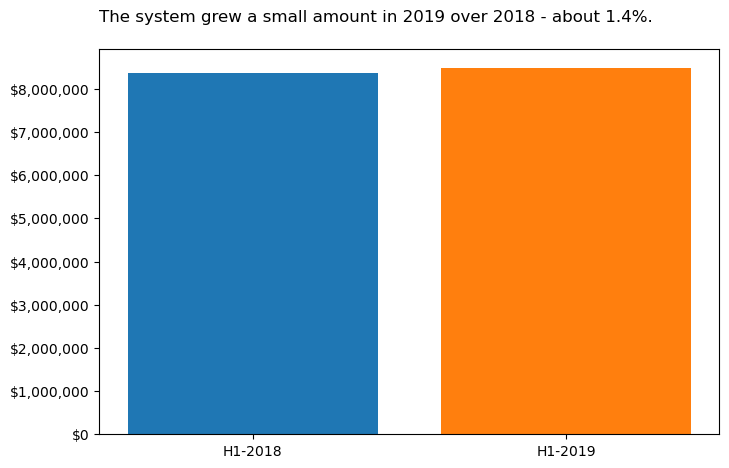

In [12]:
gb1 = rawdata1.groupby(['HALF YEAR'])['REVENUE_NET'].sum()
gb1 = gb1.drop(labels=['H2-2018'])
fig = plt.figure(figsize=(8,5)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.bar(gb1.index,
       gb1,
       color = ['tab:blue','tab:orange'])
ax.set_title('The system grew a small amount in 2019 over 2018 - about 1.4%.', pad=20, loc = 'left')
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

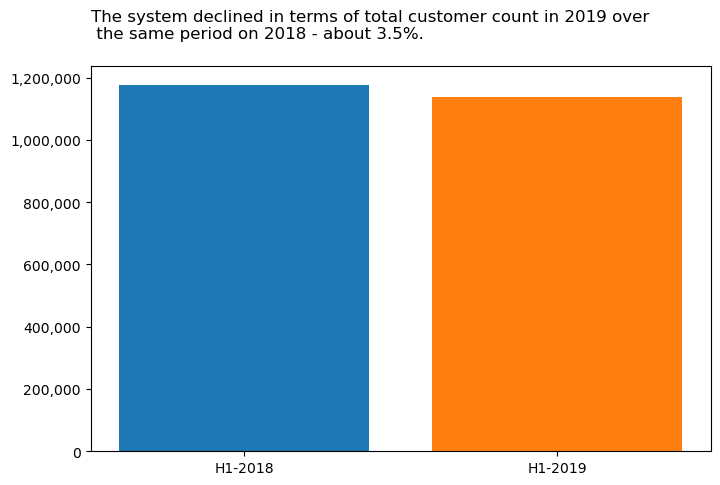

In [13]:
gb2 = rawdata2.groupby(['HALF YEAR'])['CUSTOMER_COUNT'].sum()
gb2 = gb2.drop(labels=['H2-2018'])
fig = plt.figure(figsize=(8,5)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.bar(gb2.index,
       gb2,
       color = ['tab:blue','tab:orange'])
ax.set_title('The system declined in terms of total customer count in 2019 over\n \
the same period on 2018 - about 3.5%.', pad=20, loc = 'left')
ax.yaxis.set_major_formatter("{x:,.0f}")

plt.show()

## Store Level View

In [14]:
gb2 = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['STORE'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb2.columns.name = None

column_to_move = gb2.pop("H1-2019")
gb2.insert(2, "H1-2019", column_to_move)

In [15]:
gb2.head(5)

,H1-2018,H2-2018,H1-2019
STORE,,,
1,106278,116647,104287
2,142544,157363,146512
3,116876,122008,110326
4,62613,66529,63869
5,139471,139406,121467


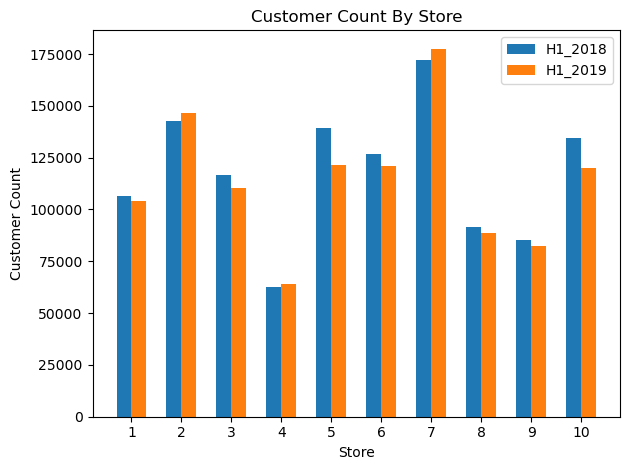

In [16]:
labels = gb2.index # Days

H1_2018 = gb2['H1-2018']
H2_2018 = gb2['H2-2018']
H1_2019 = gb2['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.3 # width of bars

fig, ax = plt.subplots()
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
# ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

## Daypart Level View

In [17]:
gb_dp = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['DAYPART'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb_dp.columns.name = None

column_to_move = gb_dp.pop("H1-2019")
gb_dp.insert(2, "H1-2019", column_to_move)

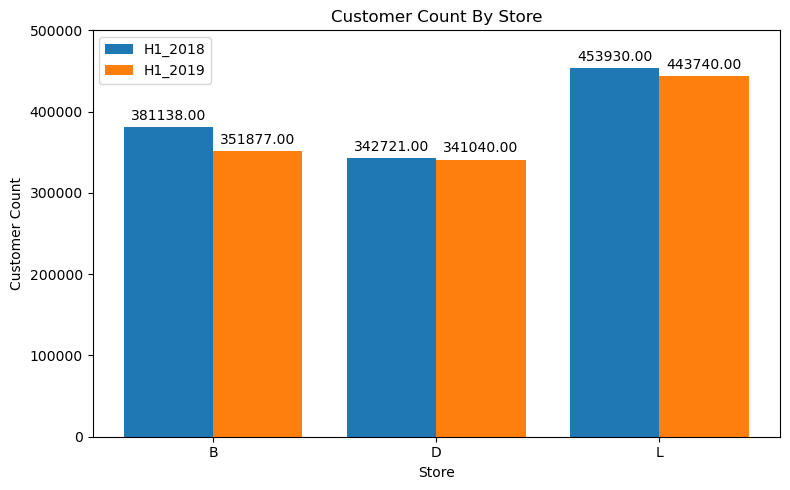

In [18]:
labels = gb_dp.index # Days

H1_2018 = gb_dp['H1-2018']
H2_2018 = gb_dp['H2-2018']
H1_2019 = gb_dp['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots(figsize=(8,5))
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,500000)
ax.legend()

ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

## Breakfast View for Stores 5 and 10

In [19]:
gb_4 = rawdata2[(rawdata2['STORE']==5) | (rawdata2['STORE']==10)]
gb_4 = gb_4[gb_4['DAYPART']=='B']

In [20]:
gb_4 = pd.pivot_table(gb_4, values='CUSTOMER_COUNT', index=['STORE'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb_4.columns.name = None

column_to_move = gb_4.pop("H1-2019")
gb_4.insert(2, "H1-2019", column_to_move)

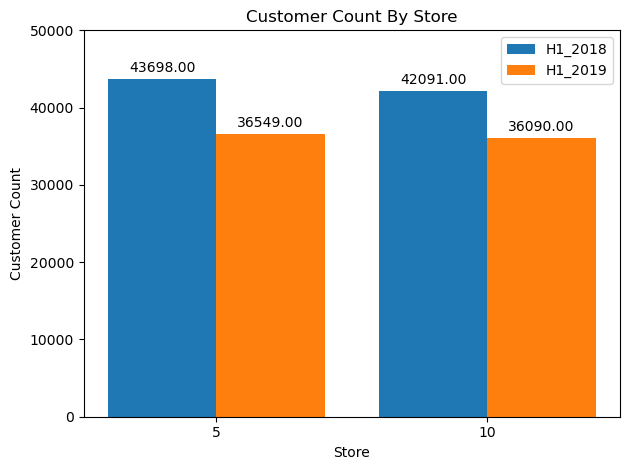

In [21]:
labels = gb_4.index # Days

H1_2018 = gb_4['H1-2018']
H2_2018 = gb_4['H2-2018']
H1_2019 = gb_4['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots()
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,50000)
ax.legend()

ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

# Forecasting Exercise

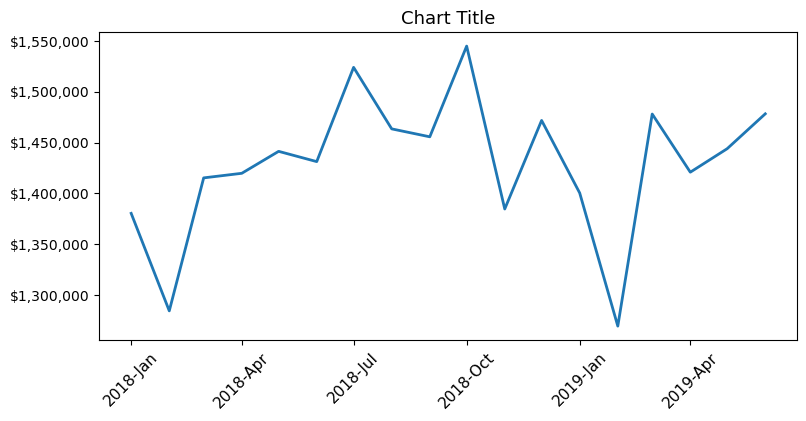

In [154]:
# producing and plotting the intial series
rawdata1 = rawdata1.groupby(['DATE'])['REVENUE_NET'].sum().to_frame()

fig = plt.figure(figsize=(9,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.set_title('Chart Title',
             fontsize = 13) # title for the chart
ax.plot(rawdata1.index,rawdata1['REVENUE_NET'],
        color = 'tab:blue',
        linewidth = 2,
        label = 'LodgingRevenue')
ax.set_xticks(ticks=rawdata1.index[::3],
              labels = rawdata1.index[::3].strftime('%Y-%b'),
              rotation=45,
              ha='center',
              fontsize = 11,
              minor=False)
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

In [159]:
# Lung Box test for White Noise
x = rawdata1.to_numpy()
df = pd.DataFrame(columns=['lb_stat', 'lb_pvalue'])
for i in range(1,17):
    ss = sm.stats.acorr_ljungbox(x, lags=[i], return_df=True)
    df.loc[i,'lb_stat'] = ss.iloc[0,0]
    df.loc[i,'lb_pvalue'] = ss.iloc[0,1]
df

,lb_stat,lb_pvalue
1,0.083959,0.772002
2,0.298484,0.861361
3,1.086487,0.780337
4,5.553595,0.235058
5,5.873238,0.318749
6,7.22881,0.300204
7,9.171865,0.240551
8,9.500623,0.301837
9,9.501373,0.392337
10,9.514684,0.484051


In [169]:
# Lung Box test for White Noise
# x = rawdata1.to_numpy()
df = pd.DataFrame(columns=['lb_stat', 'lb_pvalue'])
for i in range(1,17):
    ss = sm.stats.acorr_ljungbox(x, lags=[i], return_df=True)
    df.loc[i,'lb_stat'] = ss.iloc[0,0]
    df.loc[i,'lb_pvalue'] = ss.iloc[0,1]
df

,lb_stat,lb_pvalue
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN


In [174]:
# Lung Box test for Random Walk
from statsmodels.tsa.stattools import adfuller

results = adfuller(rawdata1)

print(f"ADF Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -1.4230190801355458
p-value: 0.5711920938966767
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749


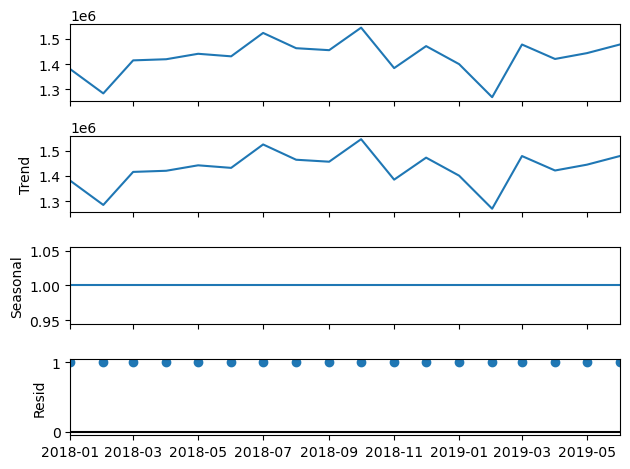

In [248]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(rawdata1, model='multiplicative', period=1)
result.plot()
pyplot.show()

In [179]:
rawdata1

,REVENUE_NET
DATE,
2018-01-01,1380400
2018-02-01,1284500
2018-03-01,1415300
2018-04-01,1419800
2018-05-01,1441400
2018-06-01,1431300
2018-07-01,1524000
2018-08-01,1463500
2018-09-01,1455700


In [223]:
forecast = rawdata1.copy()

In [224]:
forecast = forecast.iloc[6:12]

In [222]:
forecast = forecast.reset_index()

In [204]:
forecast

,DATE,REVENUE_NET
0,2018-06-01,1431300
1,2018-07-01,1524000
2,2018-08-01,1463500
3,2018-09-01,1455700
4,2018-10-01,1544900
5,2018-11-01,1384700
6,2018-12-01,1471800


In [206]:
type(forecast['DATE'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [236]:
z = pd.date_range(start="2018-01",end="2019-12",freq='MS')

In [239]:
df = pd.DataFrame(columns=['lb_stat'])

In [240]:
df.index = z

ValueError: Length mismatch: Expected axis has 0 elements, new values have 24 elements

In [243]:
row, col = 24, 1

out = pd.DataFrame.from_records([[None]*col]*row)

In [245]:
out.index = z

In [246]:
out

,0
2018-01-01,None
2018-02-01,None
2018-03-01,None
2018-04-01,None
2018-05-01,None
2018-06-01,None
2018-07-01,None
2018-08-01,None
2018-09-01,None
2018-10-01,None


In [226]:
forecast.index = z

In [227]:
forecast

,REVENUE_NET
2019-07-01,1524000
2019-08-01,1463500
2019-09-01,1455700
2019-10-01,1544900
2019-11-01,1384700
2019-12-01,1471800


AttributeError: 'DatetimeIndex' object has no attribute 'index'

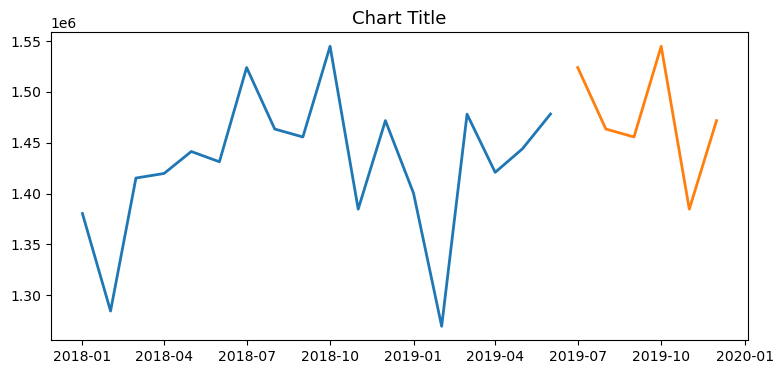

In [238]:
# producing and plotting the intial series
rawdata1 = rawdata1.groupby(['DATE'])['REVENUE_NET'].sum().to_frame()

fig = plt.figure(figsize=(9,4)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.set_title('Chart Title',
             fontsize = 13) # title for the chart
ax.plot(rawdata1.index,rawdata1['REVENUE_NET'],
        color = 'tab:blue',
        linewidth = 2,
        label = 'LodgingRevenue')
ax.plot(forecast.index,forecast['REVENUE_NET'],
        color = 'tab:orange',
        linewidth = 2,
        label = 'LodgingRevenue')
ax.set_xticks(ticks=z.index[::3],
              labels = rawdata1.index[::3].strftime('%Y-%b'),
              rotation=45,
              ha='center',
              fontsize = 11,
              minor=False)
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

In [235]:
ticks=rawdata1.index[::3] + forecast.index[::3]

TypeError: cannot add DatetimeArray and DatetimeArray

In [233]:
ticks

DatetimeIndex(['2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

# Plotting Data

In [ ]:
store = '10'
fig = plt.figure(figsize=(7,4)) # creating the figure object
ax = fig.add_subplot()
fig.suptitle('Store 1: Overall View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

plot_fun1(df_store_list,store,ax)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(7.5,7.5),sharex=True)
axes = axes.flatten()
fig.suptitle('Store 1: Daypart View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

for i,axe in enumerate(axes):
    plot_fun1(daypart_list[i],store,axe,plot_num = i,type='dp')

In [ ]:
df_store_list[0]

In [ ]:
df_store_list[1]

In [ ]:
df_store_list[3]

### Breakfast Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_brkfst_list[i],i,store, axe)

### Lunch Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_lnch_list[i],i,store, axe)

### Dinner Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_dnr_list[i],i,store, axe)

### 10 Level

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun2(df_10_list[i],i,store, axe)